## Important: Run this code cell each time you start a new session!

In [39]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install os
!pip install wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import wfdb

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [40]:
!wget -nc https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip
!unzip -n training_setA.zip

File ‘training_setA.zip’ already there; not retrieving.

Archive:  training_setA.zip


In [41]:
def load_single_file(file_path):
    df = pd.read_csv(file_path, sep="|")
    df['PatientID'] = file_path.split(os.sep)[-1][:-4]
    df['Hour'] = df.index
    keep_cols = ['PatientID', 'Age', 'Gender', 'SepsisLabel', 'Hour',
                 'HR', 'O2Sat', 'SBP', 'DBP', 'Resp']
    df = df[keep_cols]
    df.rename(columns={'Gender': 'Sex', 'SepsisLabel': 'HasSepsis'}, inplace=True)
    return df

def create_final_table():
    final_df = pd.DataFrame()
    patient_list = range(1, 11)
    patient_list = [f'p{str(s).zfill(6)}.psv' for s in patient_list]
    for f in patient_list:
        df = load_single_file(os.path.join("training", f))
        final_df = pd.concat([final_df, df])
    final_df.to_csv('sepsis.csv',index=False)
create_final_table()

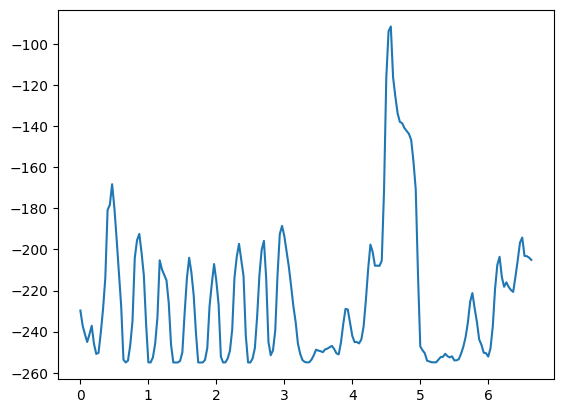

In [42]:
# Load the PPG data
user = '100004'
signals, fields = wfdb.rdsamp(f'{user}_PPG', pn_dir=f'butppg/{user}')
ppg = signals.flatten()
ppg = ppg[:200]
fs = fields['fs']
ppg_time = np.arange(len(ppg))/fs

# Save it in a DataFrame
df = pd.DataFrame()
df['Time'] = ppg_time
df['PPG'] = ppg
df.to_csv('ppg.csv', index=False)

plt.figure()
plt.plot(df['Time'], df['PPG'])
plt.show()

# Instructions

To get full credit for this assignment, we should be able to run your entire notbook from start to finish without any errors. You can check this yourself by selecting "Runtime" > "Run all" in the Google Colab menu.

# Exercise 1: Visualizing Tabular Data

This exercise will involve the sepsis dataset we used in class.

In [43]:
df = pd.read_csv("sepsis.csv")
df

,PatientID,Age,Sex,HasSepsis,Hour,HR,O2Sat,SBP,DBP,Resp
0,p000001,83.14,0,0,0,NaN,NaN,NaN,NaN,NaN
1,p000001,83.14,0,0,1,97.0,95.0,98.0,NaN,19.0
2,p000001,83.14,0,0,2,89.0,99.0,122.0,NaN,22.0
3,p000001,83.14,0,0,3,90.0,95.0,NaN,NaN,30.0
4,p000001,83.14,0,0,4,103.0,88.5,122.0,NaN,24.5
...,...,...,...,...,...,...,...,...,...,...
580,p000010,76.71,0,0,18,82.0,96.0,109.0,50.0,20.0
581,p000010,76.71,0,0,19,79.0,94.0,97.0,49.0,21.0
582,p000010,76.71,0,0,20,79.0,90.0,117.0,54.0,19.0
583,p000010,76.71,0,0,21,84.0,91.0,124.0,59.0,23.0


**(Part 1)** Create a bar graph that shows the split between males (`0`) and females (`1`) in the dataset. Remember that there are multiple entries per patient in this table. Your plot should be clearly legible and properly labeled with axis labels and a title.

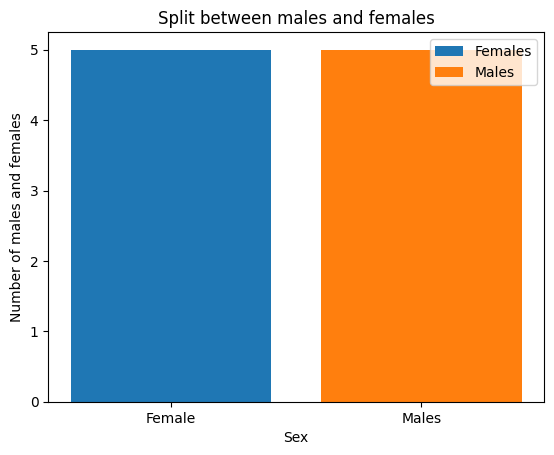

In [44]:
patient_ids = df['PatientID'].unique()

num_females = 0
num_males = 0

for i in patient_ids:
    patient = df[df['PatientID'] == i]
    sex = patient.iloc[0]['Sex']
    if sex == 0:
        num_males += 1
    else:
        num_females += 1

plt.bar('Female', num_females, label = 'Females')
plt.bar('Males', num_males, label = 'Males')
plt.xlabel('Sex')
plt.ylabel('Number of males and females')
plt.title('Split between males and females')
plt.legend()
plt.show()

**(Part 2)** Create a line graph that shows the oxygen saturation data (`O2Sat`) for patients `p000008`, `p000009`, and `p000010` over time. Your plot should be clearly legible and properly labeled with axis labels, a title, and a legend.

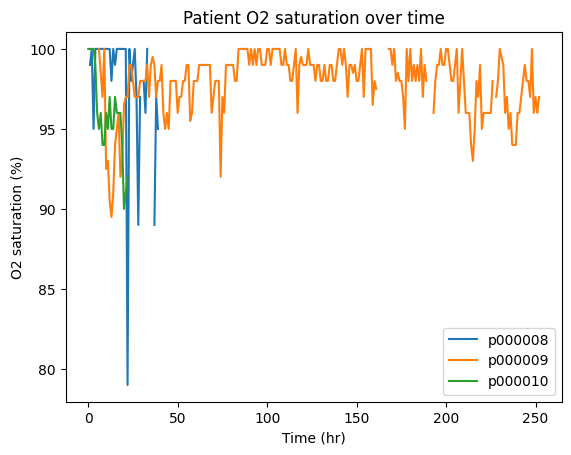

In [45]:
# Patient 8
p1_data = df[df['PatientID'] == 'p000008']
p1_OSat = p1_data['O2Sat']
p1_hour = p1_data['Hour']

# Patient 9
p2_data = df[df['PatientID'] == 'p000009']
p2_OSat = p2_data['O2Sat']
p2_hour = p2_data['Hour']

# Patient 10
p3_data = df[df['PatientID'] == 'p000010']
p3_OSat = p3_data['O2Sat']
p3_hour = p3_data['Hour']

plt.plot(p1_hour, p1_OSat, label='p000008')
plt.plot(p2_hour, p2_OSat, label='p000009')
plt.plot(p3_hour, p3_OSat, label='p000010')
plt.title('Patient O2 saturation over time')
plt.xlabel('Time (hr)')
plt.ylabel('O2 saturation (%)')
plt.legend()
plt.show()

**(Part 3)** Create a bar graph that shows the number of hours during which each patient's oxygen saturation (`O2Sat`) went below 95. Your plot should be clearly legible and properly labeled with axis labels and a title.

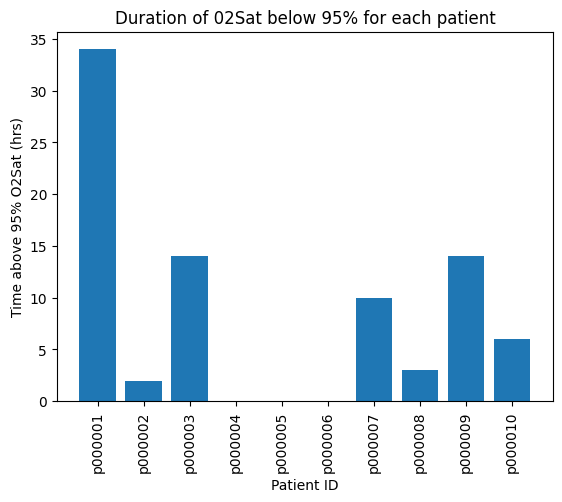

In [46]:
# Empty dictionary to store duration for each patient
patient_duration = {}

# Iterating over unique patients, filter for patient and O2Sat below 95
for patient_id in patient_ids:
  patient_data = df[(df['PatientID'] == patient_id) & (df['O2Sat'] < 95)]
  duration = patient_data['Hour'].count()
  patient_duration[patient_id] = duration

# Plot the results
plt.bar(patient_duration.keys(), patient_duration.values())
plt.xlabel('Patient ID')
plt.xticks(rotation = 90)
plt.ylabel('Time above 95% O2Sat (hrs)')
plt.title('Duration of 02Sat below 95% for each patient')
plt.show()

# Exercise 2: Working with PPG Data

This exercise will revolve real-world data that was collected from a photoplethysmography (PPG) sensor. In short, this type of sensor relies on optically measuring the amount of blood that flows in and out of a peripheral site like a fingertip to capture the cardiac waveform.

In [47]:
df = pd.read_csv("ppg.csv")
df

,Time,PPG
0,0.000000,-229.706899
1,0.033333,-237.120027
2,0.066667,-241.235545
3,0.100000,-245.031067
4,0.133333,-241.306784
...,...,...
195,6.500000,-194.187818
196,6.533333,-203.118026
197,6.566667,-203.250444
198,6.600000,-203.940514


**(Part 1)** Create a line graph that shows the PPG data over time. Your plot should be clearly legible and properly labeled with axis labels and a title.

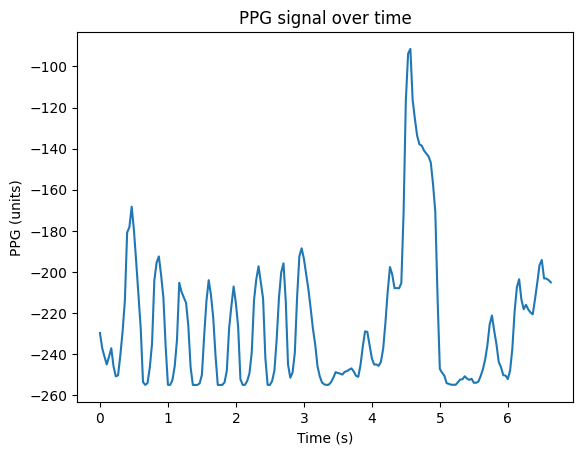

In [48]:
# import time
plt.plot(df['Time'], df['PPG'])
plt.xlabel('Time (s)')
plt.ylabel('PPG (units)')
plt.title('PPG signal over time')
plt.show()

Notice that the first half of the signal looks like a consistent heartbeat, while the second half of the signal looks less consistent. This is likely because the patient moved their fingertip or the sensor during this recording.

**(Part 2)** Write code that uses a 1-second sliding window with 0% overlap to automatically identify when the PPG signal quality is high. You can use whatever metric(s) and thresholds you deem fit to define signal quality. This code should print out the start and end time of each window when the signal quality is high.

In [49]:
def classify_ppg(df, lower_threshold, upper_threshold):
    """
    df: a DataFrame containing PPG values over time
    width: the width of the windows measured in seconds
    lower_theshold: the minimum variance that the signal should have to be considered 'good'
    upper_threshold: the maximum variance that the signal should have to be considered 'good'
    """
    # Initialize the start and end of the window
    window_size_secs = 1
    start_time = 0
    end_time = window_size_secs

    # Initialize the column for storing activity level
    df['IsSignalNoisy'] = False

    # Stop generating windows it would go past the end of the signal
    signal_duration = df['Time'].iloc[-1]
    while end_time < signal_duration:
        # Grab the current window by filtering indexes according to time
        window_idxs = (df['Time'] >= start_time) & (df['Time'] <= end_time)
        x_window = df['Time'][window_idxs]
        y_window = df['PPG'][window_idxs]

        # Calculate the variance in the window level
        window_variance = y_window.std()

        # Update the activity level if it is high
        if window_variance < lower_threshold or window_variance > upper_threshold:
            df.loc[window_idxs, 'IsSignalNoisy'] = True

        # Move the window over by a stride
        start_time += window_size_secs
        end_time += window_size_secs

    # Show the activity level using transparency
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['PPG'])
    for idx in range(1, df.shape[0]):
        if df['IsSignalNoisy'].iloc[idx]:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='r', alpha=0.5, lw=0)
        else:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='g', alpha=0.5, lw=0)
    plt.xlabel('Time (s)')
    plt.ylabel('PPG (units)')
    plt.title('Signal Quality (green = good, red = bad)')
    plt.show()

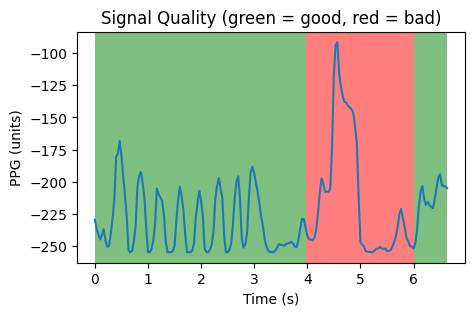

In [50]:
lower_threshold = 15 #@param {type:"slider", min:0, max:50, step:5}
upper_threshold = 30 #@param {type:"slider", min:0, max:50, step:5}
classify_ppg(df, lower_threshold, upper_threshold)

**(Part 3)** Pick the largest contiguous chunk of the PPG signal where the signal quality is high. Then, write code that will use a sliding window of your choosing to count the number of heartbeats in that part of the data.

In [51]:
"""
We can reuse the code from class as long as we express the inputs in samples
"""

def detect_peaks(df, width, stride):
    """
    df: a DataFrame containing PPG values over time
    width: the width of the windows measured in # of samples
    stride: the stride of the windows measured in # of samples
    """
    # Initialize the start and end of the window
    start_idx = 0
    end_idx = width
    middle_idx = width // 2

    # Initialize the peak counter
    peaks = {}

    # Stop generating windows it would go past the end of the signal
    signal_length = df.shape[0]
    while end_idx < signal_length:
        # Grab the current window
        x_window = df['Time'].iloc[start_idx:end_idx]
        y_window = df['PPG'].iloc[start_idx:end_idx]

        # Check if there is a peak in the middle
        if y_window.argmax() == middle_idx:
            # Update the contents of the peak counter
            peak_timestamp = x_window.values[middle_idx]
            peak_value = y_window.values[middle_idx]
            peaks[peak_timestamp] = peak_value

        # Move the window over by a stride
        start_idx += stride
        end_idx += stride

    # Show the steps overlaid on the graph
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['PPG'])
    plt.plot(peaks.keys(), peaks.values(), 'k*')
    plt.xlabel('Time (s)')
    plt.ylabel('PPG (units)')
    plt.title(f'Number of detected peaks: {len(peaks)}')
    plt.show()

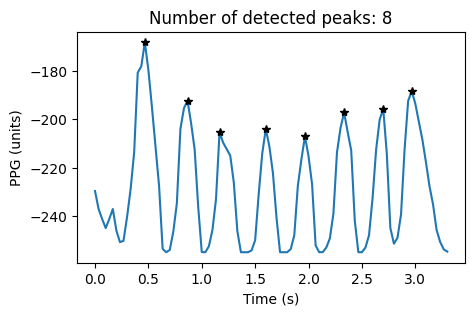

In [52]:
good_ppg = df.iloc[:100] # TODO: put your indices inside the square bracket

window_width_seconds = 0.4
sampling_rate_hz = 1/(good_ppg['Time'].iloc[1] - good_ppg['Time'].iloc[0])
window_width_samples = int(sampling_rate_hz * window_width_seconds)
detect_peaks(good_ppg, window_width_samples, 1)